In [1]:
%reload_ext autoreload
%autoreload 2

In [4]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    compress_repeated_epochs,
)
from ripple_heterogeneity.readout import predict_downstream_reduced_rank_regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions


,basepath
0,Z:\Data\AYAold\AYA10\day27
1,Z:\Data\AYAold\AYA10\day31
2,Z:\Data\AYAold\AYA10\day32
3,Z:\Data\AYAold\AYA7\day19
4,Z:\Data\AYAold\AYA7\day20
...,...
108,Z:\Data\FujisawaS\EE\EE0705fm
109,Z:\Data\FujisawaS\EE\EE0706fm
110,Z:\Data\FujisawaS\EE\EE0708fm
111,Z:\Data\HMC1\day12


In [13]:
def get_data(basepath, target_regions, reference_region, rip_exp=0.5):
    st, cm = loading.load_spikes(
        basepath, brainRegion=[*target_regions, *reference_region]
    )
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    ripples = loading.load_ripples_events(basepath)
    ripple_epochs = nel.EpochArray([np.array([ripples.peaks, ripples.peaks]).T]).expand(
        rip_exp
    )

    ep_df = loading.load_epoch(basepath)
    ep_df = compress_repeated_epochs.main(ep_df, epoch_name="sleep")
    session_epoch = nel.EpochArray(
        [np.array([ep_df.startTime.iloc[0], ep_df.stopTime.iloc[-1]]).T]
    )

    # locate pre task post structure
    idx, _ = functions.find_pre_task_post(ep_df.environment)
    if idx is None:
        return None, None, None, None, None, None, None, None

    ep_df = ep_df[idx]
    ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])

    state_dict = loading.load_SleepState_states(basepath)
    nrem_epochs = nel.EpochArray(state_dict["NREMstate"])
    wake_epochs = nel.EpochArray(state_dict["WAKEstate"])

    return (
        st,
        cm,
        ripple_epochs,
        ep_epochs,
        ep_df,
        session_epoch,
        nrem_epochs,
        wake_epochs,
    )


In [15]:
basepath = "Z:\Data\HMC1\day12"

reference_region=["CA1"]
target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]
rip_exp=0.5

(
    st,
    cm,
    ripple_epochs,
    ep_epochs,
    ep_df,
    session_epoch,
    nrem_epochs,
    wake_epochs,
) = get_data(
    basepath,
    target_regions,
    reference_region,
    rip_exp=rip_exp,
)

In [16]:
st,ripple_epochs,nrem_epochs,wake_epochs,session_epoch

(<SpikeTrainArray at 0x1eea34c8610: 313 units> at 20000 Hz,
 <EpochArray at 0x1ee88b33b50: 8,214 epochs> of length 1:41:46:393 hours,
 <EpochArray at 0x1ee88b33a60: 92 epochs> of length 3:09:52 hours,
 <EpochArray at 0x1ee88b336d0: 98 epochs> of length 3:12:11 hours,
 <EpochArray at 0x1ee88b33550: 1 epoch> of length 6:51:58:841 hours)

In [36]:
ca1_idx = (
    cm.brainRegion.str.contains("CA1").values
    & (cm.deepSuperficial == "Deep")
    & (cm.putativeCellType.str.contains("Pyr"))
)

target_idx = (
    cm.brainRegion.str.contains("PFC").values
    & cm.putativeCellType.str.contains("Pyr").values
)

In [31]:
bst = st[ripple_epochs[0]].bin(ds=0.001).smooth(sigma=0.015)

In [38]:
bst.data.shape

(313, 1000)

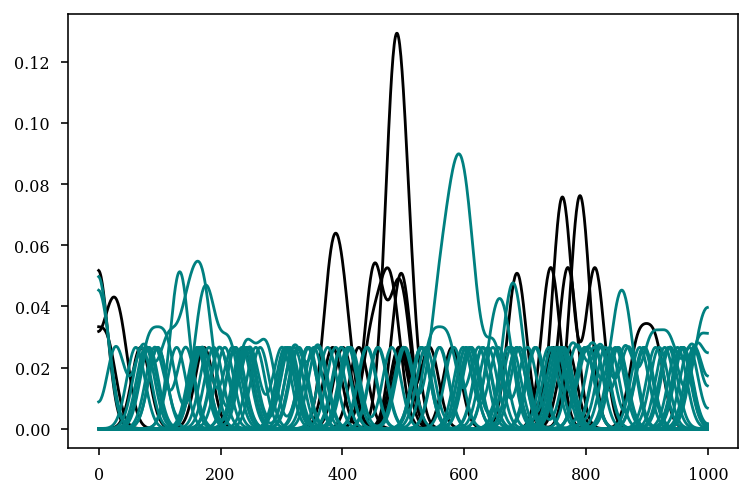

In [41]:
plt.plot(bst.data[ca1_idx,:].T,color="k")
plt.plot(bst.data[target_idx,:].T,color="teal")
plt.show()

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(bst.data)


# X_train, X_test, y_train, y_test = train_test_split(
#     X[ca1_idx,:],
#     X[target_idx,:],
#     test_size=0.4,
#     random_state=42,
#     shuffle=False,
# )

reg = LinearRegression().fit(X[ca1_idx,:].T, X[target_idx,:].T)
reg.score(X[ca1_idx,:].T, X[target_idx,:].T)

0.7308535091325323

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X[ca1_idx,:].T,
    X[target_idx,:].T,
    test_size=0.4,
    random_state=42,
    shuffle=True,
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((600, 29), (400, 29), (600, 87), (400, 87))

In [86]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

(0.7357936979710349, 0.716586851472347)

In [90]:
from ripple_heterogeneity.utils import (
    kernel_reduced_rank_ridge_regression,
)
from sklearn.model_selection import GridSearchCV

def run_grid_search(X_train, y_train, n_grid=10, cv=5, max_rank=30):
    """
    grid_search: grid search for the reduced rank regressor
    """

    rank_grid = np.arange(1, min(X_train.shape[1], y_train.shape[1], max_rank)).astype(
        int
    )

    parameters_grid_search = {"rank": rank_grid}

    rrr = kernel_reduced_rank_ridge_regression.ReducedRankRegressor()

    # folds = TimeSeriesSplit(n_splits=cv)

    grid_search = GridSearchCV(
        rrr,
        parameters_grid_search,
        cv=cv,
        scoring="neg_mean_squared_error",
    )
    return grid_search.fit(X_train, y_train)

grid_search_result = run_grid_search(X_train, y_train, n_grid=10, cv=5, max_rank=30)


reg = kernel_reduced_rank_ridge_regression.ReducedRankRegressor()
reg.rank = int(grid_search_result.best_params_["rank"])

reg.fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

(0.7094822517219477, 0.6946804982474518)

In [91]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, reg.predict(X_test))

0.25316191108591224

In [ ]:
sns.heatmap(X_train.T)
plt.show()
sns.heatmap(X_test.T)
plt.show()
# sns.heatmap(reg.predict(X[ca1_idx,:].T).T)
# plt.show()

In [73]:
X[ca1_idx,:].shape, X[target_idx,:].shape

((29, 1000), (87, 1000))

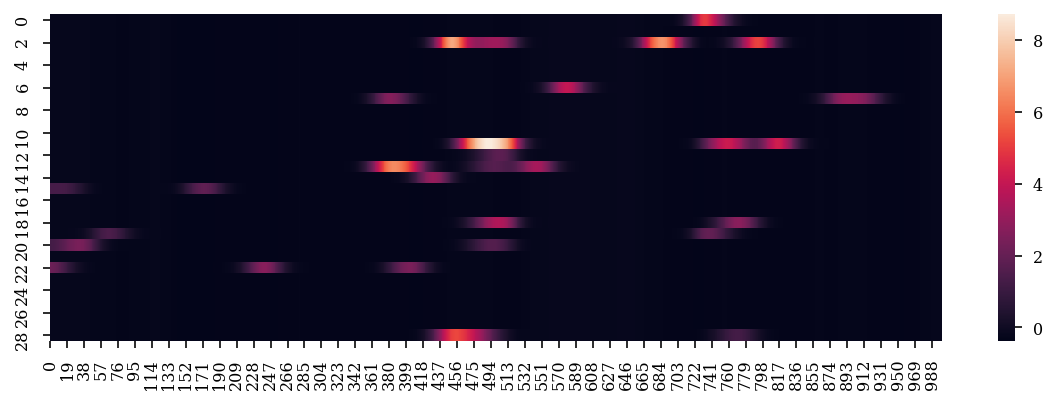

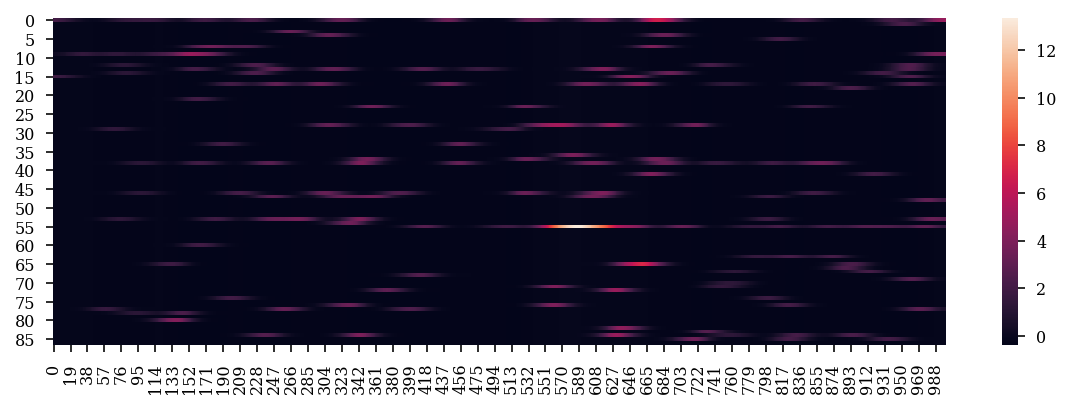

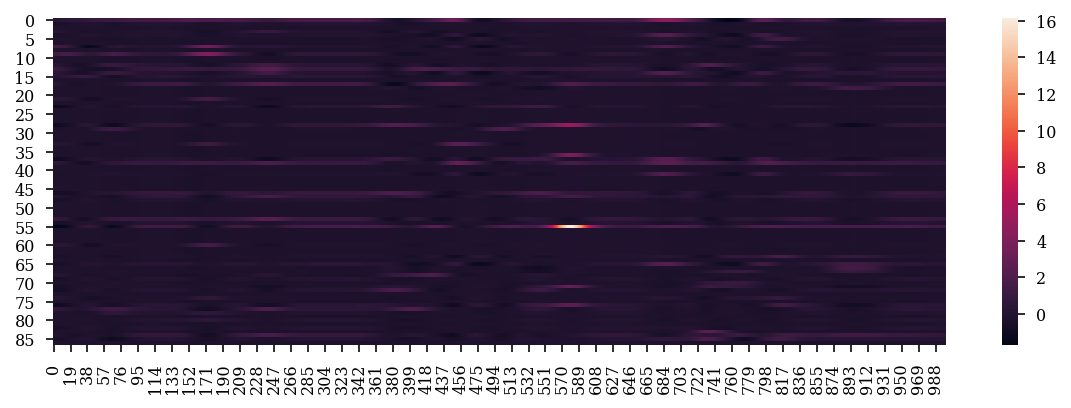

In [92]:
plt.figure(figsize=(10,3))
sns.heatmap(X[ca1_idx,:])
plt.show()

plt.figure(figsize=(10,3))
sns.heatmap(X[target_idx,:])
plt.show()

plt.figure(figsize=(10,3))
sns.heatmap(reg.predict(X[ca1_idx,:].T).T)
plt.show()


In [55]:
X[ca1_idx,:].shape, X[target_idx,:].shape

((29, 1000), (87, 1000))

In [52]:
X_train.shape

(600, 29)

<AxesSubplot:>

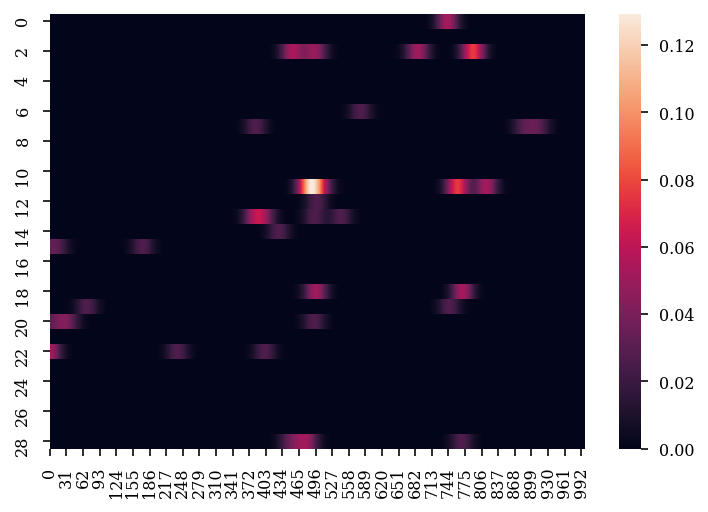

In [43]:
sns.heatmap(bst.data[ca1_idx,:])